<a href="https://colab.research.google.com/github/Danil-Kazakov/Data-HW4/blob/main/OverfittingHomeWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [7]:
df = pd.read_csv('bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

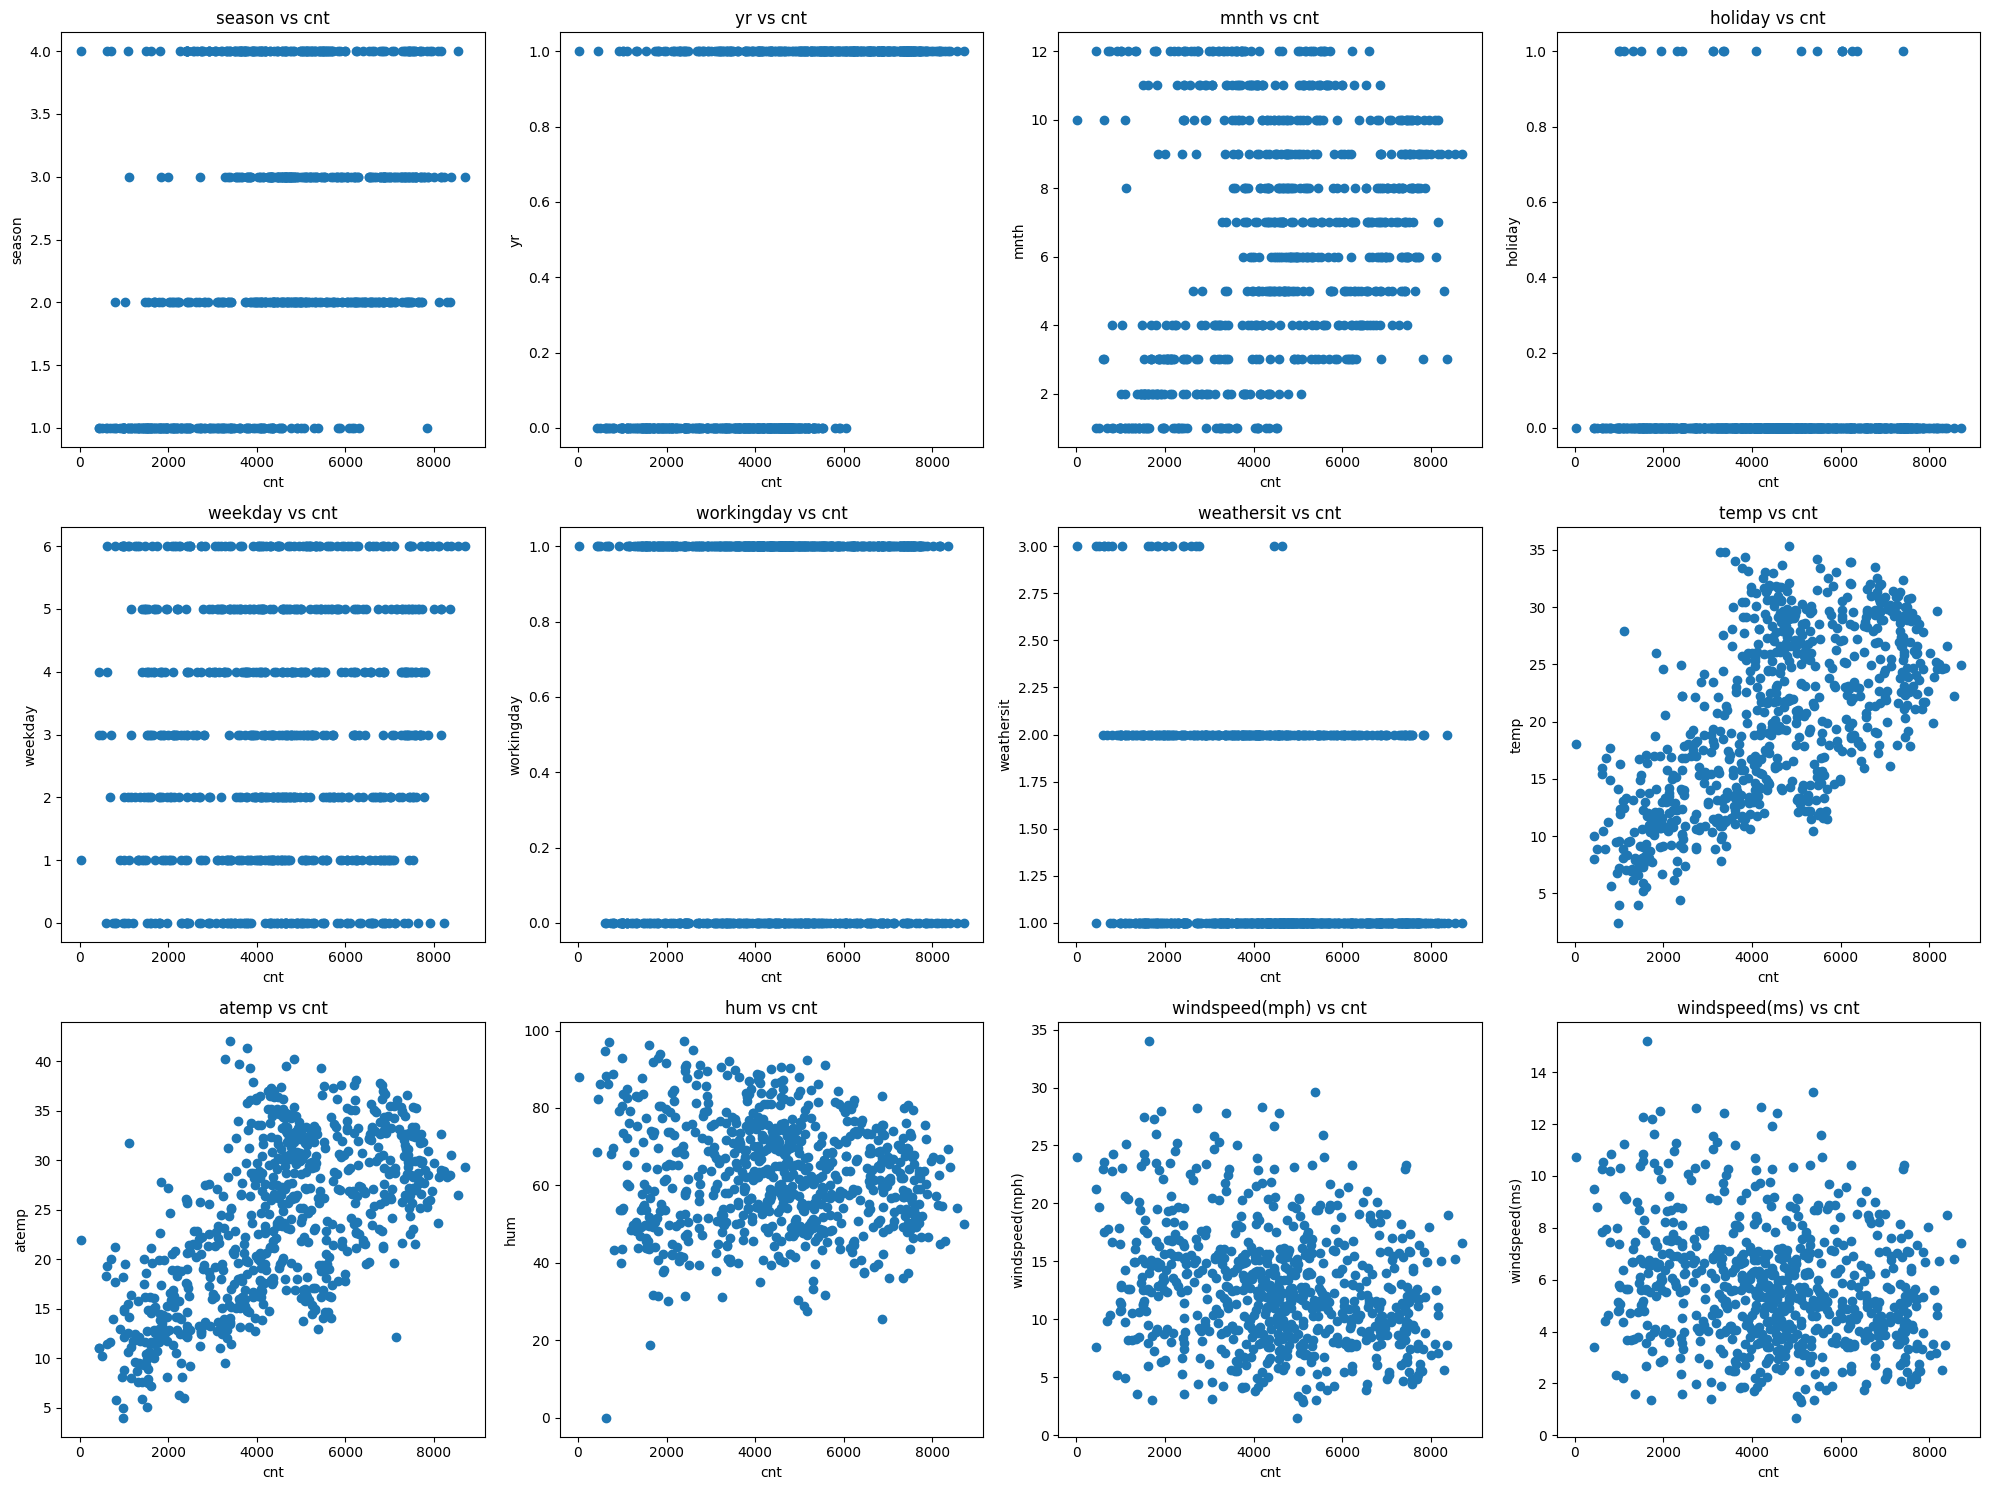

In [8]:
atributes = df.columns[:-1]
plt.figure(figsize=(20, 15))

for i, attribute in enumerate(atributes):
  plt.subplot(3, 4, i + 1)
  plt.scatter(df['cnt'], df[attribute])
  plt.xlabel('cnt')
  plt.ylabel(attribute)
  plt.title(f'{attribute} vs cnt')

plt.tight_layout()
plt.show()

# Яким є характер залежності кількості прокатів від місяця?
# Відповідь: Характер залежності від місяця: Немає чіткої лінійної залежності, хоча варіації існують.

# Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.
# Відповідь: Temp, Num

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [9]:
correlations_with_cnt = df.iloc[:, :-1].corrwith(df['cnt'])
corr = df.corr()
print(correlations_with_cnt)
print(corr)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64
                  season        yr      mnth   holiday   weekday  workingday  \
season          1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr             -0.001844  1.000000 -0.001792  0.007954 -0.005461   -0.002013   
mnth            0.831440 -0.001792  1.000000  0.019191  0.009509   -0.005901   
holiday        -0.010537  0.007954  0.019191  1.000000 -0.101960   -0.253023   
weekday        -0.003080 -0.005461  0.009509 -0.101960  1.000000    0.035790   
workingday      0.012485 -0.002013 -0.005901 -0.253023  0.035790    1.000000   
weathersit      0.019211 -0.048727  0.043528 -0.034627  0.031087    0.061200   
temp            0.334

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [10]:
selected_columns = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

pairwise_correlations = df[selected_columns].corr()
print(pairwise_correlations)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [11]:
mean = df.mean()
print(mean)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [12]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [13]:
SEED = 42
df_shuffled = shuffle(df, random_state=SEED)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [19]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [20]:
X = df.drop(columns='cnt')
y = df['cnt']

regressor = LinearRegression()

regressor.fit(X, y)

weights = regressor.coef_

feature_names = X.columns
weights_with_names = list(zip(feature_names, weights))

for feature, weight in weights_with_names:
    print(f'{feature}: {weight}')

season: 514.2756689772416
yr: 2043.9333206099773
mnth: -40.96317631503962
holiday: -519.3860417173415
weekday: 68.49569506058863
workingday: 121.29281595858514
weathersit: -606.4542679476724
temp: 48.994172947818015
atemp: 71.9163310082323
hum: -10.230641893838651
windspeed(mph): 2400995993962.544
windspeed(ms): -5371028038579.01


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [21]:
X = df.drop(columns='cnt')
y = df['cnt']

lasso = Lasso()
lasso.fit(X, y)
lasso_weights = lasso.coef_

print("Lasso Weights:")
for feature, weight in zip(X.columns, lasso_weights):
    print(f'{feature}: {weight}')

Lasso Weights:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [22]:
X = df.drop(columns='cnt')
y = df['cnt']

ridge = Ridge()
ridge.fit(X, y)
ridge_weights = ridge.coef_

print("\nRidge Weights:")
for feature, weight in zip(X.columns, ridge_weights):
    print(f'{feature}: {weight}')


Ridge Weights:
season: 507.8018818505763
yr: 2029.0890541970502
mnth: -38.470897279124635
holiday: -493.2780154838191
weekday: 69.11396965165964
workingday: 121.5244250292943
weathersit: -605.205555373153
temp: 49.31676759598743
atemp: 71.7859872733456
hum: -10.383394500484615
windspeed(mph): -31.93550169428455
windspeed(ms): -14.276040263842843


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [23]:
X = df.drop(columns='cnt')
y = df['cnt']

alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)

    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print("Lasso Coefficients:")
for alpha, coef in zip(alphas, coefs_lasso):
    print(f'alpha={alpha}: {coef}')

print("\nRidge Coefficients:")
for alpha, coef in zip(alphas, coefs_ridge):
    print(f'alpha={alpha}: {coef}')

Lasso Coefficients:
alpha=1: [ 506.55127865 2036.2316677   -38.07827029 -484.65194619   68.93837479
  118.44759759 -604.56671189   51.36326059   69.91273749  -10.3527052
  -38.34106761   -0.        ]
alpha=51: [ 363.38298622 1818.17950113   -0.           -0.           55.24105548
    0.         -291.33521188   44.34993053   83.88557181  -18.81320743
  -43.35682101   -0.        ]
alpha=101: [ 294.88974192 1604.19359695    9.74208093   -0.           37.4493754
    0.           -0.           37.46764176   95.93389064  -26.48659474
  -48.19495616   -0.        ]
alpha=151: [ 188.43126588 1400.65605911   33.03502814   -0.           24.19007609
    0.           -0.           33.15169023  102.54337981  -26.88669007
  -47.85305889   -0.        ]
alpha=201: [  81.95521364 1197.14314149   56.33124542   -0.           10.96345655
    0.           -0.           27.55035178  110.33369233  -27.29091458
  -47.46769509   -0.        ]
alpha=251: [  0.         994.19323854  73.37527257  -0.           0.
 

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

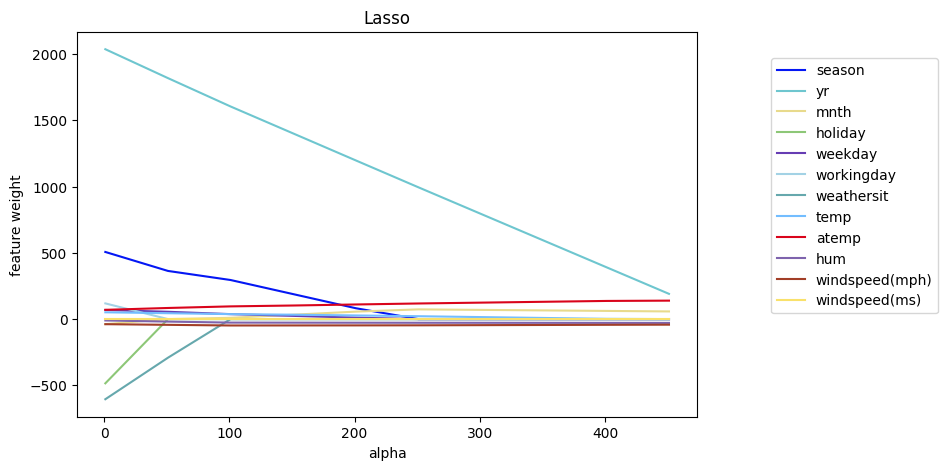

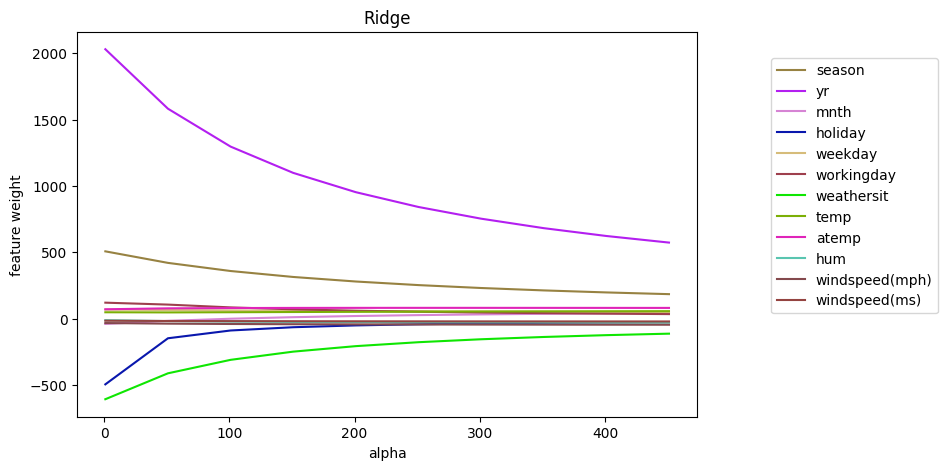

In [24]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

1. Lasso
2. Значення alpha зануляє ваги
3. Так, можна. I Ridge залишається достатьно малими.
4. L1, Lasso

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [33]:
def create_plot(data, title, xlabel, ylabel, figsize=None, min=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)


    x = data[0]
    y = data[1]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

regressor.coef_.shape=(20,)
regressor.alphas.shape=(20,)
regressor.mse_path_.shape=(20, 3)
regressor.alphas_=array([96, 91, 86, 81, 76, 71, 66, 61, 56, 51, 46, 41, 36, 31, 26, 21, 16,
       11,  6,  1])


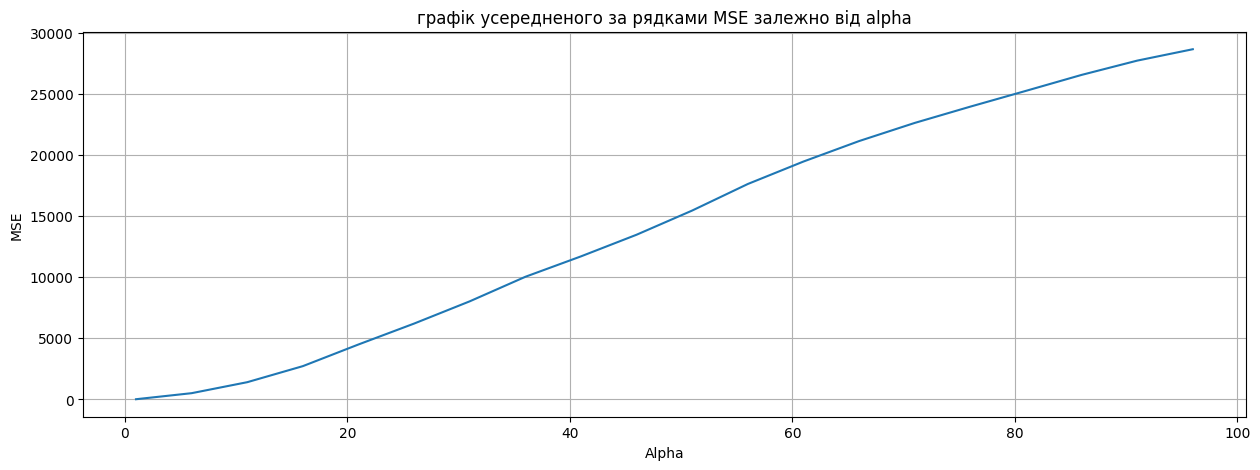

In [34]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(random_state=SEED, alphas=alphas, cv=3)
regressor.fit(X, y)
print(f"{regressor.coef_.shape=}")
print(f"{regressor.alphas.shape=}")
print(f"{regressor.mse_path_.shape=}")
print(f"{regressor.alphas_=}")

mse_values = np.mean(regressor.mse_path_, axis=1)
# print(f"{mse_values=}")

data = np.vstack((regressor.alphas_, mse_values))
# print(f"{data=}")
create_plot(data,"графік усередненого за рядками MSE залежно від alpha","Alpha","MSE")


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alpha values corresponding to minimum MSE in each fold:
Fold 1: 0.1000
Fold 2: 0.1000
Fold 3: 0.1000
Fold 4: 0.1000
Fold 5: 0.1000


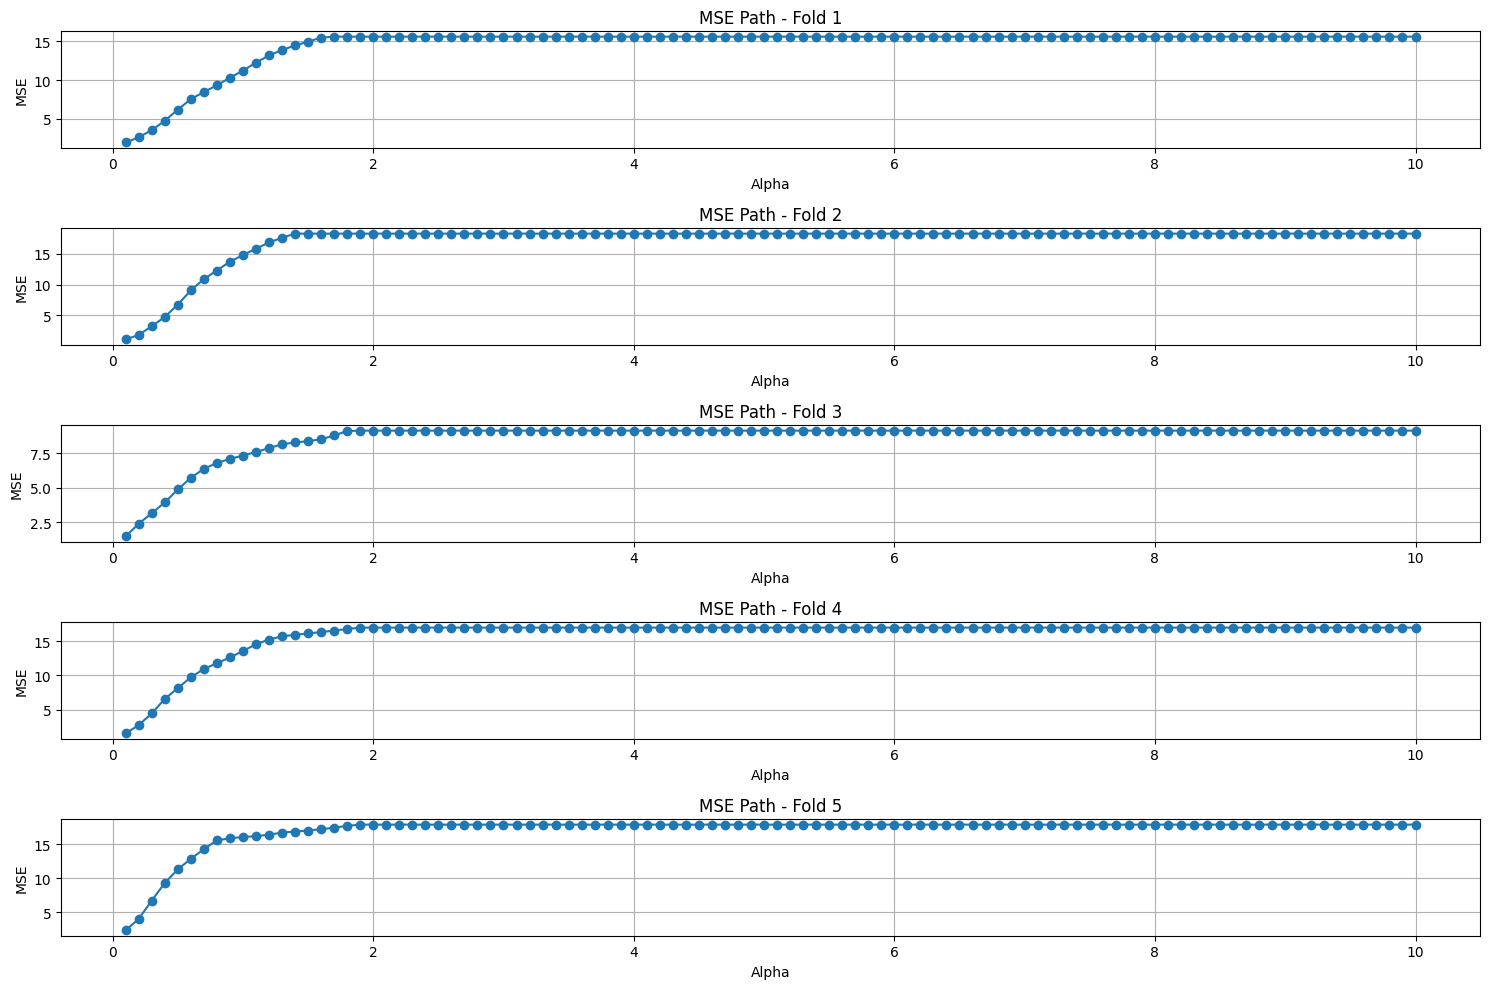

In [37]:
np.random.seed(42)
n_samples, n_features = 100, 20
X = np.random.randn(n_samples, n_features)
coef = np.random.randn(n_features)
y = np.dot(X, coef) + np.random.normal(size=n_samples)

alphas = np.arange(0.1, 10.1, 0.1)

regressor = LassoCV(alphas=alphas, cv=5)
regressor.fit(X, y)

min_alpha_per_fold = regressor.alphas_[np.argmin(regressor.mse_path_, axis=0)]

print("Alpha values corresponding to minimum MSE in each fold:")
for fold, alpha in enumerate(min_alpha_per_fold):
    print(f"Fold {fold + 1}: {alpha:.4f}")

plt.figure(figsize=(15, 10))
for i in range(regressor.mse_path_.shape[1]):
    plt.subplot(regressor.mse_path_.shape[1], 1, i + 1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], marker='o')
    plt.title(f"MSE Path - Fold {i + 1}")
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.grid(True)

plt.tight_layout()
plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

Top 4 features with highest positive coefficients:
Feature 14: 0.6791688950522186
Feature 18: 0.6700772761346271
Feature 9: 0.6419483116611194
Feature 8: 0.5915674789766847


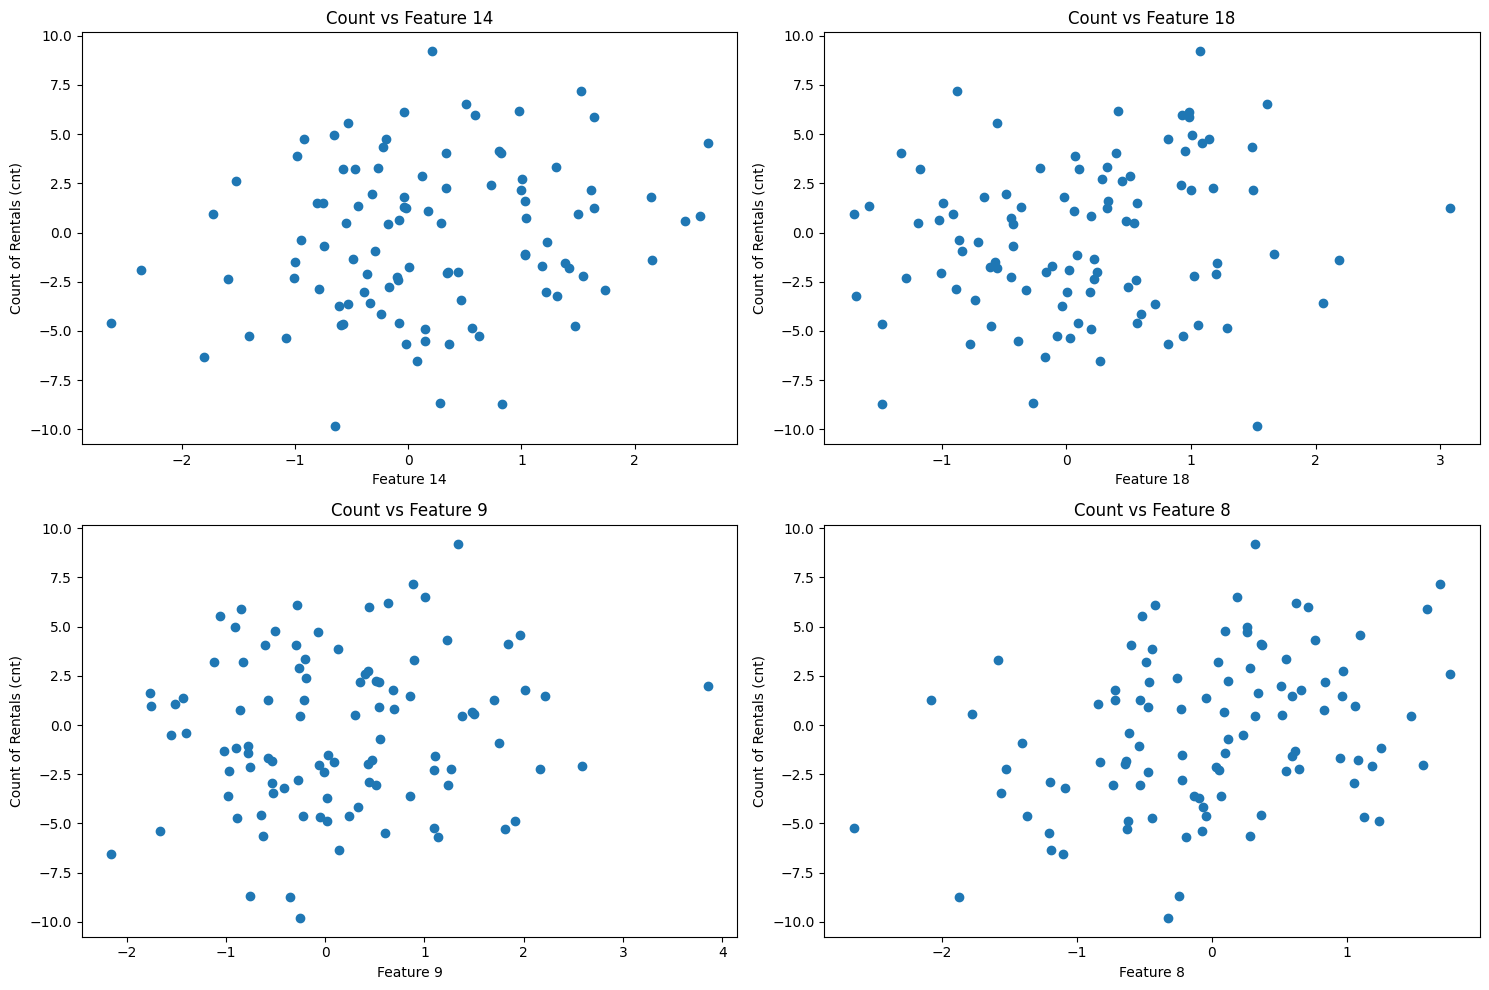

In [38]:
top_positive_features = np.argsort(-regressor.coef_)[:4]
print("Top 4 features with highest positive coefficients:")
for idx in top_positive_features:
    print(f"Feature {idx}: {regressor.coef_[idx]}")

plt.figure(figsize=(15, 10))
for i, feature_idx in enumerate(top_positive_features):
    plt.subplot(2, 2, i + 1)
    plt.scatter(X[:, feature_idx], y, marker='o')
    plt.xlabel(f"Feature {feature_idx}")
    plt.ylabel("Count of Rentals (cnt)")
    plt.title(f"Count vs Feature {feature_idx}")

plt.tight_layout()
plt.show()

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

Top 3 features with highest absolute negative coefficients:
Feature 10: -1.6157971166414116
Feature 4: -1.6994681469029513
Feature 17: -1.8113152615308286


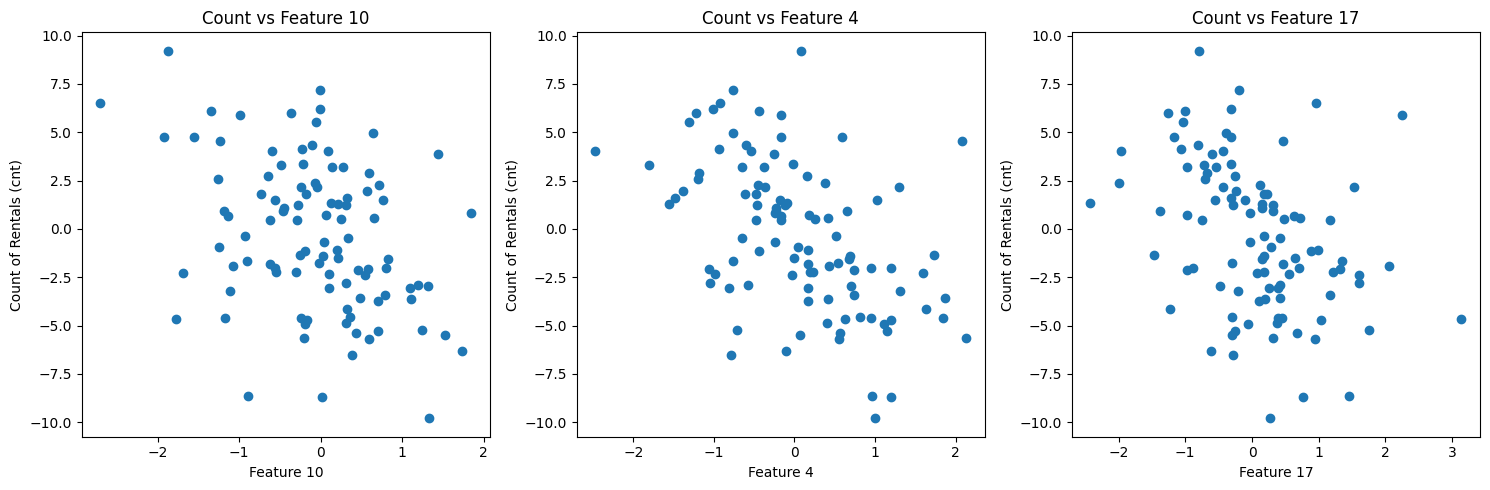

In [39]:
top_negative_features = np.argsort(np.abs(regressor.coef_))[-3:]
print("Top 3 features with highest absolute negative coefficients:")
for idx in top_negative_features:
    print(f"Feature {idx}: {regressor.coef_[idx]}")

plt.figure(figsize=(15, 5))
for i, feature_idx in enumerate(top_negative_features):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, feature_idx], y, marker='o')
    plt.xlabel(f"Feature {feature_idx}")
    plt.ylabel("Count of Rentals (cnt)")
    plt.title(f"Count vs Feature {feature_idx}")

plt.tight_layout()
plt.show()

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

Features with coefficients close to zero:
Feature 1: 0.0
Feature 6: 0.0
Feature 15: -0.0


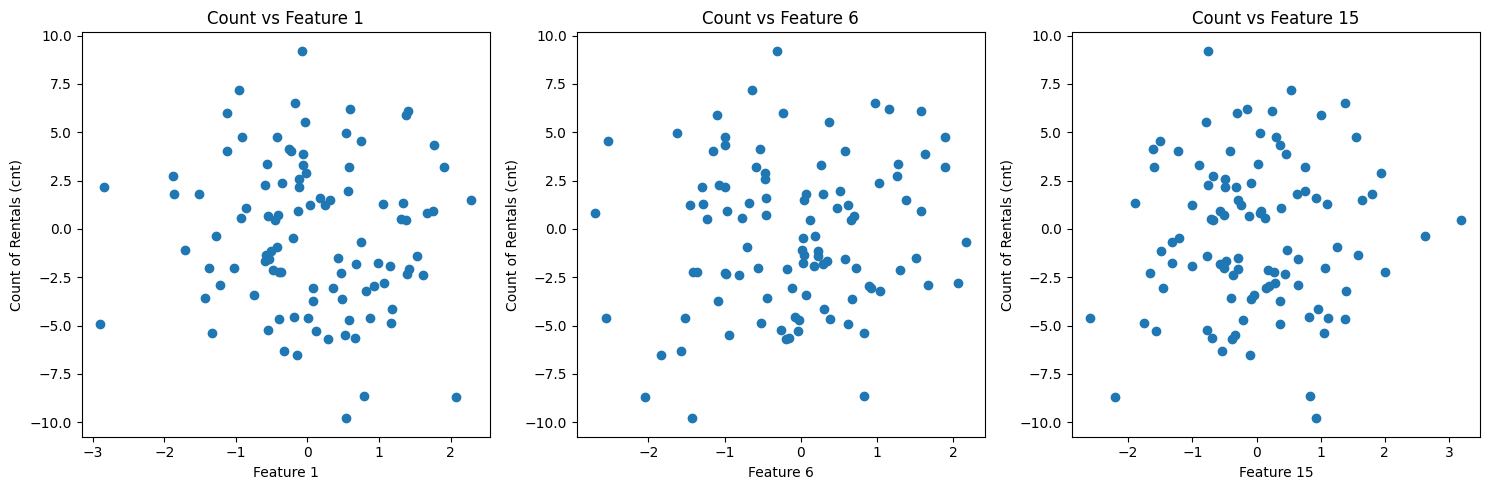

In [40]:
near_zero_features = np.where(np.abs(regressor.coef_) < 1e-3)[0]
print("Features with coefficients close to zero:")
for idx in near_zero_features:
    print(f"Feature {idx}: {regressor.coef_[idx]}")

# Візуалізація залежностей cnt від вибраних ознак
plt.figure(figsize=(15, 5))
for i, feature_idx in enumerate(near_zero_features):
    plt.subplot(1, len(near_zero_features), i + 1)
    plt.scatter(X[:, feature_idx], y, marker='o')
    plt.xlabel(f"Feature {feature_idx}")
    plt.ylabel("Count of Rentals (cnt)")
    plt.title(f"Count vs Feature {feature_idx}")

plt.tight_layout()
plt.show()

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.